# DELAY SUM - DREGON DATASET

A ideia desse Jupyter é usar o dataset Dregon para aplicar o algoritmo Delay Sum.
Segundo o dataset, http://dregon.inria.fr/datasets/dregon/, as coordenadas X, Y e Z em metros dos oito microfones são:

mic0 = [0.0420, 0.0615, -0.0410]

mic1 = [-0.0420, 0.0615, 0.0410]

mic2 = [-0.0615, 0.0420, -0.0410]

mic3 = [-0.0615, -0.0420, 0.0410]

mic4 = [-0.0420, -0.0615, -0.0410]

mic5 = [0.0420, -0.0615, 0.0410]

mic6 = [0.0615, -0.0420, -0.0410]

mic7 = [0.0615, 0.0420, 0.0410]

Para fazer uma configuração semelhante ao ReSpeaker 4-Mic-Array, vou utilizar apenas quatro microfones com o mesmo valor no eixo Z, mic1, mic3, mic5 e mic7.

In [1]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import math
import numpy as np

### Importando um áudio qualquer

Segundo o dataset, os áudios são nomeados como se segue:

XX_YY_ZZ.wav where XX denotes the relative azimuth, YY the relative elevation and ZZ the relative distance of the loudspeaker from the array.

O dataset foi gravado com 44100 Hz, e, como o librosa importa os áudios sempre com 22kHz, é preciso colocar sr=None como parâmetro adicional da função abaixo.

In [2]:
originalAudio, freqAmostragem = librosa.load('/home/dimi/Downloads/datasets/DREGON_clean_recordings_speech/60_-30_2.4__2.wav', sr=None, mono=False)

In [3]:
freqAmostragem

44100

Ouvindo os microfones que serão utilizados (mesmo eixo Z):

In [4]:
Audio(data=originalAudio[1], rate=freqAmostragem)

In [5]:
Audio(data=originalAudio[3], rate=freqAmostragem)

In [6]:
Audio(data=originalAudio[5], rate=freqAmostragem)

In [7]:
Audio(data=originalAudio[7], rate=freqAmostragem)

### Função para verificar o delay entre dois sinais pela correlação

Essa função foi copiada e colada do algoritmo que já havia sido desenvolvido antes. É preciso mandar o argumento maxDelay, que é a quantidade de amostras contidas no maior delay possível entre dois microfones quaisquer.

In [8]:
def verificarDelay(sinalA, sinalB, maxDelay=15, verbose=False):
    
    # Verificando se os dois sinais tem o mesmo tamanho e se maxDelay é compatível
    if len(sinalA) != len(sinalB) or maxDelay >= len(sinalA)-1 :
        return False
    
    # Sei que o maior delay possível (em qtd de amostras) é maxDelay. Portanto, em cada iteração, 
    # a comparação entre os sinais para gerar a correlação se dará com arrays de tamanho 
    # len(sinal) - maxDelay
    tamanho = len(sinalA) - maxDelay
    
    # O delay será a qtd de amostras pra trás ou para frente que há
    # entre o sinal B em relação ao sinal A. Negativo significa que B está adiantado, 0 que não há
    # delay e positivo que está atrasado.
    delay = 0
    melhorCorrelacao = -1
    arrayCorrelacoes = []
    
    inicioA = 0
    fimA    = inicioA + tamanho
    inicioB = len(sinalB) - tamanho
    fimB    = inicioB + tamanho
    
    # Fazendo as iterações e calculando a correlação entre os sinais
    for i in range(-maxDelay, maxDelay+1):
        
        # Calculando a correlação da iteração atual
        corrAtual = np.corrcoef(sinalA[inicioA:fimA], sinalB[inicioB:fimB])[0][1]
        
        # Verificando se encontramos uma correlacao maior ainda para atualizar o delay
        if corrAtual > melhorCorrelacao:
            melhorCorrelacao = corrAtual
            delay = -i
        
        # Printando as iterações se verbose estiver ligado
        if verbose == True:
            arrayCorrelacoes.append(corrAtual)
            plt.title("Delay " + str(i))
            plt.plot(sinalA[inicioA:fimA])
            plt.plot(sinalB[inicioB:fimB])
            plt.show()
            print("Sinal A:", int(inicioA), "até", int(fimA))
            print("Sinal B:", int(inicioB), "até", int(fimB))
            print("Correlação Atual:", corrAtual)
            print("Melhor Correlação:", melhorCorrelacao, "(Delay " + str(delay) + ")\n\n\n")
            
        # Fazendo os indexes dos arrays da próxima iteração. De i = -maxDelay até 0, o Sinal A 
        # fica parado e o Sinal B vem vindo pra trás. A partir de i = 1 até maxDelay, o Sinal B
        # fica parado e o Sinal A vai embora.
        if i < 0:
            inicioB -= 1
            fimB     = inicioB + tamanho
        else:
            inicioA += 1
            fimA     = inicioA + tamanho
         
    # Se o verbose estiver ligado eu printo as correlações em função do delay tb
    if verbose == True:
        plt.title("Correlações em função dos delays")
        plt.plot(arrayCorrelacoes)
        plt.show()
    
    # Retornando o delay
    return delay

A função definirDelayMaximo pode calcular a quantidade de amostras do maior delay possível entre dois microfones. Basta enviar o tamanho do lado do array quadrado.

In [9]:
def definirDelayMaximo(freqAmostragem, L, velocidadeSom=340):
    
    # O delay máximo (em qtd de amostras) dar-se-á na diagonal dos microfones
    diagonal     = math.sqrt(2 * (L**2))
    tempo        = diagonal / velocidadeSom
    qtdAmostras  = freqAmostragem * tempo
    
    # Adicionando mais 1 amostra pra garantir
    return int(qtdAmostras + 1)

### Verificando o funcionamento da função calculando o delay entre os microfones

A grande cagada é que cada microfone está numa aresta diferente do quadrado. Talvez seja necessário fazer uma troca de base, mas por enquanto da pra calcular o tamanho da aresta de boas.

In [10]:
coordenadasMic1 = [-0.0420, 0.0615]
coordenadasMic3 = [-0.0615, -0.0420]
coordenadasMic5 = [0.0420, -0.0615]
coordenadasMic7 = [0.0615, 0.0420]

vetorLado = [coordenadasMic1[0] - coordenadasMic3[0], coordenadasMic1[1] - coordenadasMic3[1]]
tamanhoLado = math.sqrt(vetorLado[0]**2 + vetorLado[1]**2)

delayMax = definirDelayMaximo(freqAmostragem, L=tamanhoLado)
print(delayMax)

20


Mostrando como a função faz o cálculo:

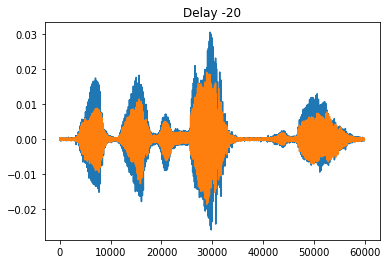

Sinal A: 0 até 59956
Sinal B: 20 até 59976
Correlação Atual: 0.22664099905244278
Melhor Correlação: 0.22664099905244278 (Delay 20)





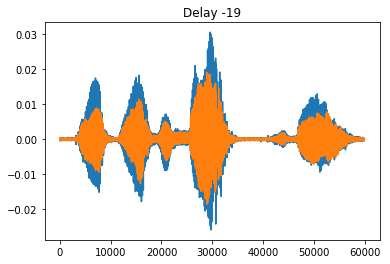

Sinal A: 0 até 59956
Sinal B: 19 até 59975
Correlação Atual: 0.30084656093363205
Melhor Correlação: 0.30084656093363205 (Delay 19)





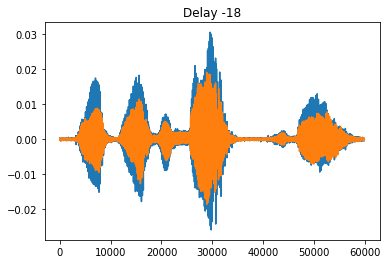

Sinal A: 0 até 59956
Sinal B: 18 até 59974
Correlação Atual: 0.3846293091966372
Melhor Correlação: 0.3846293091966372 (Delay 18)





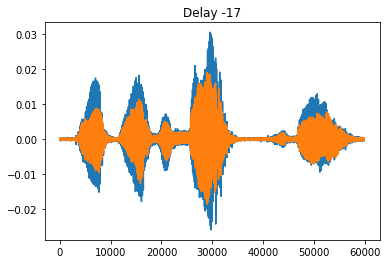

Sinal A: 0 até 59956
Sinal B: 17 até 59973
Correlação Atual: 0.4776614617465067
Melhor Correlação: 0.4776614617465067 (Delay 17)





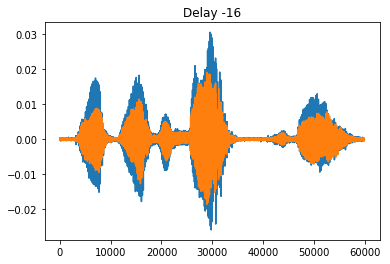

Sinal A: 0 até 59956
Sinal B: 16 até 59972
Correlação Atual: 0.5759883131579083
Melhor Correlação: 0.5759883131579083 (Delay 16)





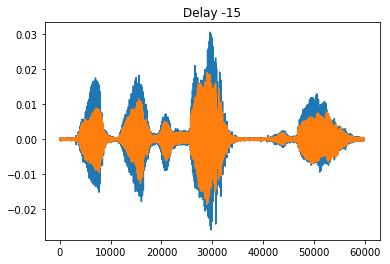

Sinal A: 0 até 59956
Sinal B: 15 até 59971
Correlação Atual: 0.6717375208329346
Melhor Correlação: 0.6717375208329346 (Delay 15)





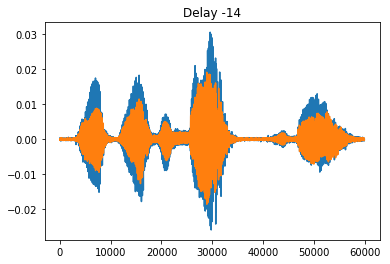

Sinal A: 0 até 59956
Sinal B: 14 até 59970
Correlação Atual: 0.7544912782577016
Melhor Correlação: 0.7544912782577016 (Delay 14)





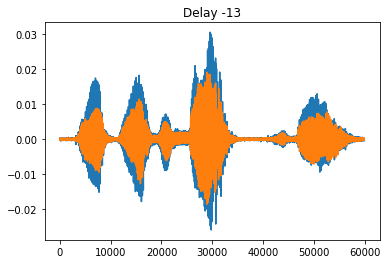

Sinal A: 0 até 59956
Sinal B: 13 até 59969
Correlação Atual: 0.8137688726331592
Melhor Correlação: 0.8137688726331592 (Delay 13)





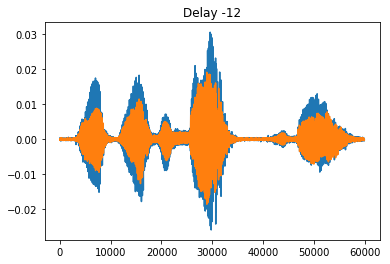

Sinal A: 0 até 59956
Sinal B: 12 até 59968
Correlação Atual: 0.8419960112524033
Melhor Correlação: 0.8419960112524033 (Delay 12)





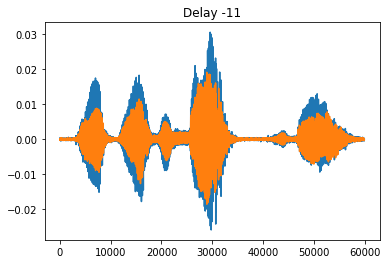

Sinal A: 0 até 59956
Sinal B: 11 até 59967
Correlação Atual: 0.8370657995816043
Melhor Correlação: 0.8419960112524033 (Delay 12)





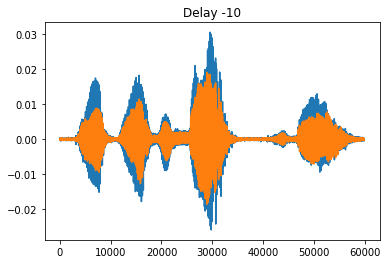

Sinal A: 0 até 59956
Sinal B: 10 até 59966
Correlação Atual: 0.8032650396954953
Melhor Correlação: 0.8419960112524033 (Delay 12)





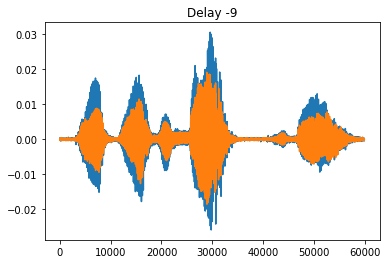

Sinal A: 0 até 59956
Sinal B: 9 até 59965
Correlação Atual: 0.7499265247357301
Melhor Correlação: 0.8419960112524033 (Delay 12)





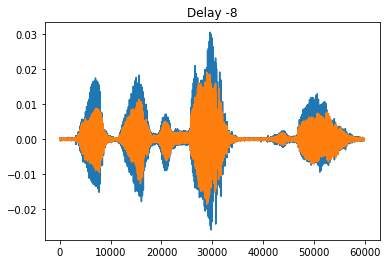

Sinal A: 0 até 59956
Sinal B: 8 até 59964
Correlação Atual: 0.6887178258483174
Melhor Correlação: 0.8419960112524033 (Delay 12)





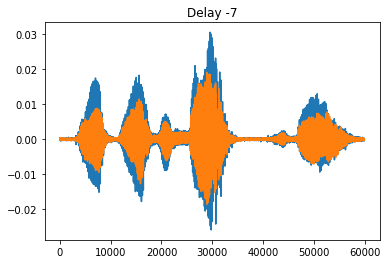

Sinal A: 0 até 59956
Sinal B: 7 até 59963
Correlação Atual: 0.6297091006873853
Melhor Correlação: 0.8419960112524033 (Delay 12)





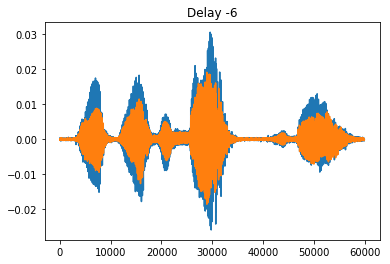

Sinal A: 0 até 59956
Sinal B: 6 até 59962
Correlação Atual: 0.5790100649573788
Melhor Correlação: 0.8419960112524033 (Delay 12)





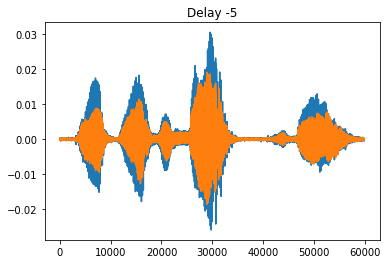

Sinal A: 0 até 59956
Sinal B: 5 até 59961
Correlação Atual: 0.5375074799197666
Melhor Correlação: 0.8419960112524033 (Delay 12)





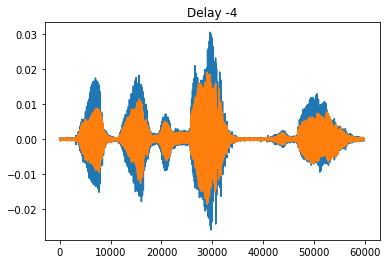

Sinal A: 0 até 59956
Sinal B: 4 até 59960
Correlação Atual: 0.5021351320906322
Melhor Correlação: 0.8419960112524033 (Delay 12)





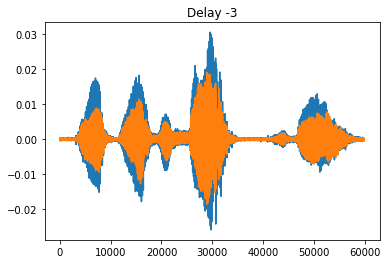

Sinal A: 0 até 59956
Sinal B: 3 até 59959
Correlação Atual: 0.46786844790070375
Melhor Correlação: 0.8419960112524033 (Delay 12)





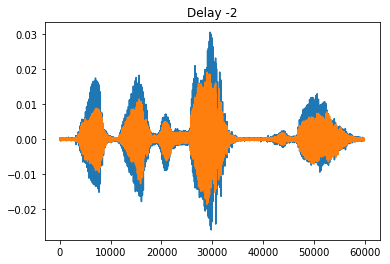

Sinal A: 0 até 59956
Sinal B: 2 até 59958
Correlação Atual: 0.43025672644735496
Melhor Correlação: 0.8419960112524033 (Delay 12)





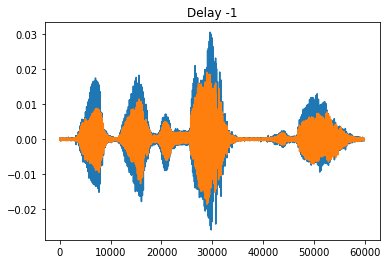

Sinal A: 0 até 59956
Sinal B: 1 até 59957
Correlação Atual: 0.3869363851622765
Melhor Correlação: 0.8419960112524033 (Delay 12)





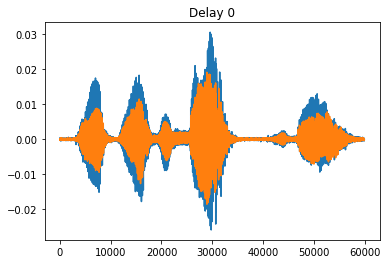

Sinal A: 0 até 59956
Sinal B: 0 até 59956
Correlação Atual: 0.33825562352999816
Melhor Correlação: 0.8419960112524033 (Delay 12)





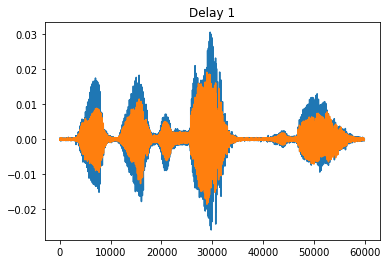

Sinal A: 1 até 59957
Sinal B: 0 até 59956
Correlação Atual: 0.2866123823720585
Melhor Correlação: 0.8419960112524033 (Delay 12)





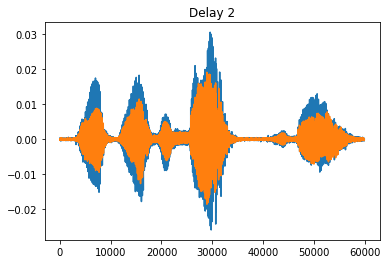

Sinal A: 2 até 59958
Sinal B: 0 até 59956
Correlação Atual: 0.23518027147180198
Melhor Correlação: 0.8419960112524033 (Delay 12)





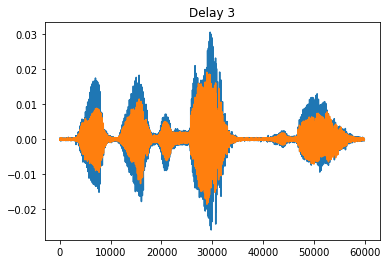

Sinal A: 3 até 59959
Sinal B: 0 até 59956
Correlação Atual: 0.18642776086437401
Melhor Correlação: 0.8419960112524033 (Delay 12)





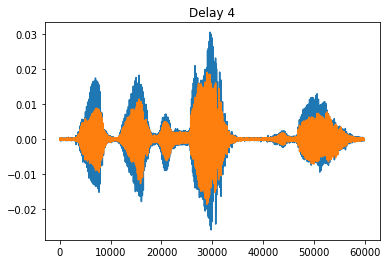

Sinal A: 4 até 59960
Sinal B: 0 até 59956
Correlação Atual: 0.14082762705795016
Melhor Correlação: 0.8419960112524033 (Delay 12)





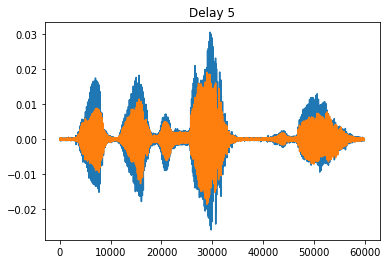

Sinal A: 5 até 59961
Sinal B: 0 até 59956
Correlação Atual: 0.09669912562093395
Melhor Correlação: 0.8419960112524033 (Delay 12)





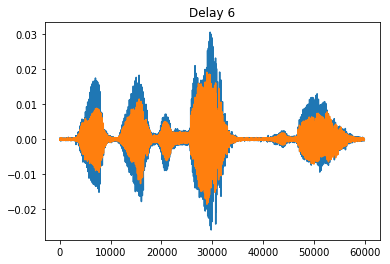

Sinal A: 6 até 59962
Sinal B: 0 até 59956
Correlação Atual: 0.050647452963787615
Melhor Correlação: 0.8419960112524033 (Delay 12)





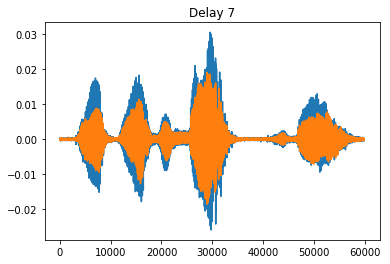

Sinal A: 7 até 59963
Sinal B: 0 até 59956
Correlação Atual: -0.000708666881749095
Melhor Correlação: 0.8419960112524033 (Delay 12)





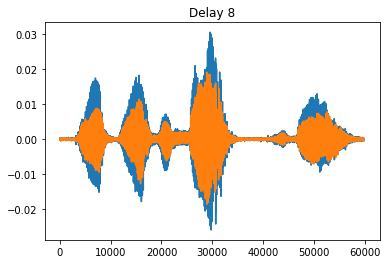

Sinal A: 8 até 59964
Sinal B: 0 até 59956
Correlação Atual: -0.05937234607536902
Melhor Correlação: 0.8419960112524033 (Delay 12)





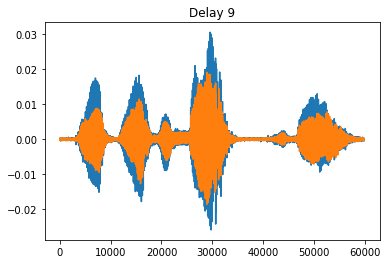

Sinal A: 9 até 59965
Sinal B: 0 até 59956
Correlação Atual: -0.12465984007810244
Melhor Correlação: 0.8419960112524033 (Delay 12)





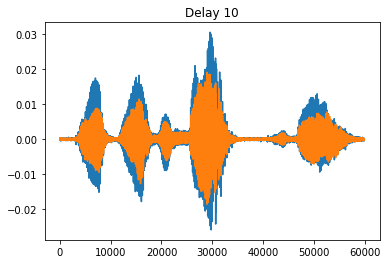

Sinal A: 10 até 59966
Sinal B: 0 até 59956
Correlação Atual: -0.1934928321524802
Melhor Correlação: 0.8419960112524033 (Delay 12)





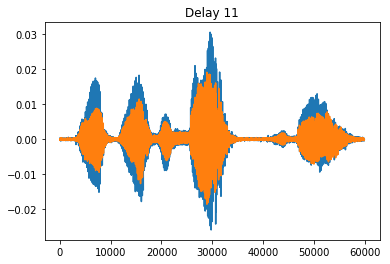

Sinal A: 11 até 59967
Sinal B: 0 até 59956
Correlação Atual: -0.2611705986432889
Melhor Correlação: 0.8419960112524033 (Delay 12)





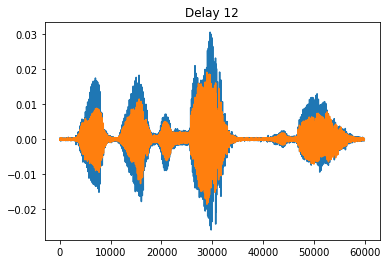

Sinal A: 12 até 59968
Sinal B: 0 até 59956
Correlação Atual: -0.32328203163205643
Melhor Correlação: 0.8419960112524033 (Delay 12)





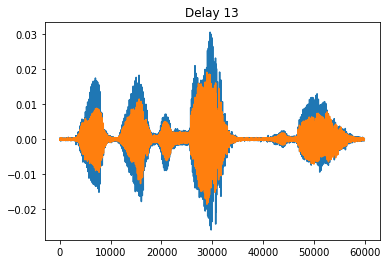

Sinal A: 13 até 59969
Sinal B: 0 até 59956
Correlação Atual: -0.37672594292589134
Melhor Correlação: 0.8419960112524033 (Delay 12)





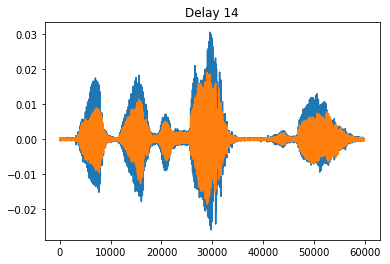

Sinal A: 14 até 59970
Sinal B: 0 até 59956
Correlação Atual: -0.42075317899902226
Melhor Correlação: 0.8419960112524033 (Delay 12)





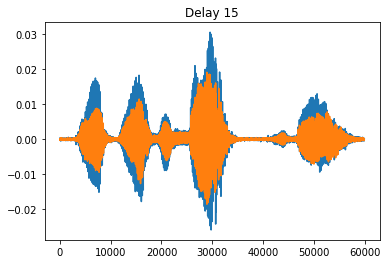

Sinal A: 15 até 59971
Sinal B: 0 até 59956
Correlação Atual: -0.45627634315316107
Melhor Correlação: 0.8419960112524033 (Delay 12)





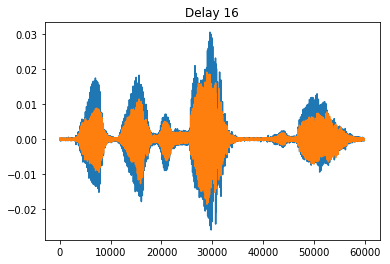

Sinal A: 16 até 59972
Sinal B: 0 até 59956
Correlação Atual: -0.4853227449164436
Melhor Correlação: 0.8419960112524033 (Delay 12)





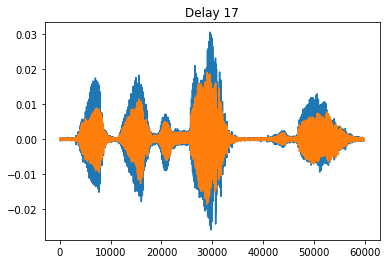

Sinal A: 17 até 59973
Sinal B: 0 até 59956
Correlação Atual: -0.5093876643193156
Melhor Correlação: 0.8419960112524033 (Delay 12)





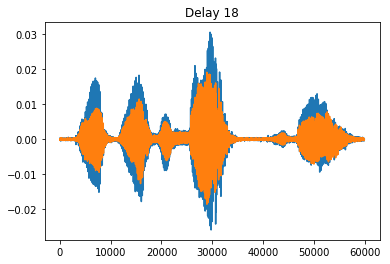

Sinal A: 18 até 59974
Sinal B: 0 até 59956
Correlação Atual: -0.5289317465473861
Melhor Correlação: 0.8419960112524033 (Delay 12)





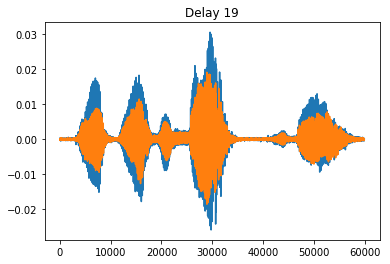

Sinal A: 19 até 59975
Sinal B: 0 até 59956
Correlação Atual: -0.5425929735972564
Melhor Correlação: 0.8419960112524033 (Delay 12)





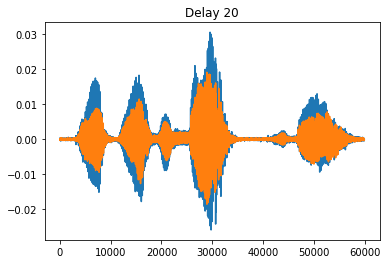

Sinal A: 20 até 59976
Sinal B: 0 até 59956
Correlação Atual: -0.5480830242394916
Melhor Correlação: 0.8419960112524033 (Delay 12)





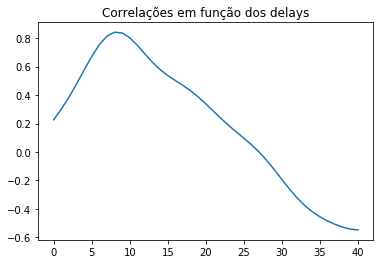

12

In [11]:
verificarDelay(originalAudio[1], originalAudio[3], maxDelay=delayMax, verbose=True)

Calculando o delay entre os microfones tendo o mic1 como referência.

In [12]:
delay13 = verificarDelay(originalAudio[1], originalAudio[3], maxDelay=delayMax)
delay15 = verificarDelay(originalAudio[1], originalAudio[5], maxDelay=delayMax)
delay17 = verificarDelay(originalAudio[1], originalAudio[7], maxDelay=delayMax)

print(delay13)
print(delay15)
print(delay17)

12
9
-3


## Implementando o produto interno

http://www.labbookpages.co.uk/audio/beamforming/delayCalc.html

### Passando a origem pra cima do microfone 1

In [13]:
coordenadasOriginaisMic1 = np.array([-0.0420, 0.0615, 0.0410])
coordenadasOriginaisMic3 = np.array([-0.0615, -0.0420, 0.0410])
coordenadasOriginaisMic5 = np.array([0.0420, -0.0615, 0.0410])
coordenadasOriginaisMic7 = np.array([0.0615, 0.0420, 0.0410])

coordenadasNovasMic1 = coordenadasOriginaisMic1 - coordenadasOriginaisMic1
coordenadasNovasMic3 = coordenadasOriginaisMic3 - coordenadasOriginaisMic1
coordenadasNovasMic5 = coordenadasOriginaisMic5 - coordenadasOriginaisMic1
coordenadasNovasMic7 = coordenadasOriginaisMic7 - coordenadasOriginaisMic1

In [14]:
print(coordenadasNovasMic1)
print(coordenadasNovasMic3)
print(coordenadasNovasMic5)
print(coordenadasNovasMic7)

[0. 0. 0.]
[-0.0195 -0.1035  0.    ]
[ 0.084 -0.123  0.   ]
[ 0.1035 -0.0195  0.    ]


### Resolvendo o sistema com mínimos quadrados

https://riptutorial.com/numpy/example/16034/find-the-least-squares-solution-to-a-linear-system-with-np-linalg-lstsq

#### Exemplo de como usar a função

In [15]:
# Definindo a equação matricial
A = np.array([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,1]])
b = np.array([1,2,3,4])

# Resolvendo x
x, residuals, rank, s = np.linalg.lstsq(A,b, rcond=None)

print(x)

[1. 2. 3. 4.]


#### Aplicando no problema dos microfones

A matriz dos coeficientes será as coordenadas dos microfones 3, 5 e 7 e a matriz b será os delays multiplicados pela velocidade do som.

|m3x m3y m3z| |wx| |vSom.delay13|

|m5x m5y m5z|.|wy|=|vSom.delay15|

|m7x m7y m7z| |wz| |vSom.delay17|

In [16]:
A = np.array([coordenadasNovasMic3.tolist(),
              coordenadasNovasMic5.tolist(),
              coordenadasNovasMic7.tolist()])
b = np.array([(delay13/freqAmostragem)*340, (delay15/freqAmostragem)*340, (delay17/freqAmostragem)*340])

x, residuals, rank, s = np.linalg.lstsq(A,b, rcond=None)
print(x)

[-0.37845023 -0.82258191  0.        ]


### Definindo algumas funções pra ajudar

In [17]:
def vetorUnitario(vetor):
    return vetor/np.linalg.norm(vetor)

def anguloEntreDoisVetores(v1, v2):
    v1Unitario = vetorUnitario(v1)
    v2Unitario = vetorUnitario(v2)
    return np.arccos(np.clip(np.dot(v1Unitario, v2Unitario), -1.0, 1.0))

def anguloAzimutal(vetor):
    return np.arctan(vetor[1]/vetor[0])
    
def anguloElevacao(vetor):
    return anguloEntreDoisVetores([vetor[0], vetor[1], 0], vetor)

def radParaGrau(angulo):
    return (angulo*180)/math.pi

In [18]:
x=x+coordenadasOriginaisMic1

In [19]:
print("Ângulo Azimutal:", radParaGrau(anguloAzimutal(x)))
print("Ângulo de Elevação:", radParaGrau(anguloElevacao(x)))

Ângulo Azimutal: 61.082090644523284
Ângulo de Elevação: 2.699709956567404
